In [1]:
%matplotlib inline
import sys
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.io import ascii
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde

In [100]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%autoreload 2
# importing plotting and locus tools: 
sys.path.append('../src')
sys.path.append('../paper/notebooks')
import LocusTools as lt
import PlotTools as pt
import paperPlots as pp

## read Stripe 82 SDSS-Gaia data for plots...   

In [3]:
datafile = '../data/Stripe82GaiaEDR3.csv'
s82gaia = Table.read(datafile) 
# reddening corrected SDSS colors
df = s82gaia
df['Ar'] = df['AR_val']
C = lt.extcoeff()
for b in ['u', 'g', 'i', 'z']:  
    df['A'+b] = C[b]*df['Ar']  
# and now apply reddening corrections
df['ug'] = df['u_mMed'] - df['g_mMed'] - (df['Au']-df['Ag'])
df['gr'] = df['g_mMed'] - df['r_mMed'] - (df['Ag']-df['Ar'])
df['ri'] = df['r_mMed'] - df['i_mMed'] - (df['Ar']-df['Ai'])
df['iz'] = df['i_mMed'] - df['z_mMed'] - (df['Ai']-df['Az'])
df['gi'] = df['gr'] + df['ri'] 
df['rmag'] = df['r_mMed']
# for plots, wrapped RA
ra = df['ra_gaia'] 
df['raW'] = np.where(ra > 180, ra-360, ra)

In [4]:
## a few subsamples for plots
# u flux limit (and r band - but just one source rejected)
rMax = 22.0
uMin = 12.0 
uMax = 22.0 
flag = (s82gaia['r_mMed']<rMax)&(s82gaia['u_mMed']>uMin)&(s82gaia['u_mMed']<uMax) 
s82gaiaB = s82gaia[flag]
# for fitting MS and giants
flag = (s82gaiaB['gi']>0.2)&(s82gaiaB['gi']<3.5)
s82gaiaPhD = s82gaiaB[flag]
# good parallax distance
piSNR = s82gaia['pi']/s82gaia['piErr']
s82gaiaPi = s82gaia[piSNR > 20]  
print(len(s82gaia), len(s82gaiaB), len(s82gaiaPhD), len(s82gaiaPi))

841200 415279 409312 63102


## empirical SDSS locus 

In [5]:
datafile = '../data/LocusData/MSandRGBcolors_v1.3.txt'
Lok = lt.LSSTsimsLocus(fixForStripe82=True, datafile=datafile)
print(np.min(Lok['FeH']), np.max(Lok['FeH']))

Fixing input Mr-FeH-colors grid to agree with the SDSS v4.2 catalog
-2.5 0.0


In [6]:
# for plotting, sequences for 3 values of FeH
# selecting a few tracks at fixed metallicity
FeH0 =  0.5
FeH1 = -1.5
FeH2 = -2.5
L0 = Lok[(Lok['FeH']>FeH0-0.01)&(Lok['FeH']<FeH0+0.01)]
L1 = Lok[(Lok['FeH']>FeH1-0.01)&(Lok['FeH']<FeH1+0.01)]
L2 = Lok[(Lok['FeH']>FeH2-0.01)&(Lok['FeH']<FeH2+0.01)]
Ls = []
Ls.append(L0)
Ls.append(L1)
Ls.append(L2)
FeHlocus3vals = [FeH0, FeH1, FeH2]

## Bob Abel's white dwarf locii

In [7]:
import pandas as pd

In [8]:
datafile = '../../BobAbel/White-Dwarfs/WD.csv'
WD = pd.read_csv(datafile)
datafile = '../../BobAbel/White-Dwarfs/WDMD.csv'
WDMD = pd.read_csv(datafile)

made plot: plot3diagsBA.png


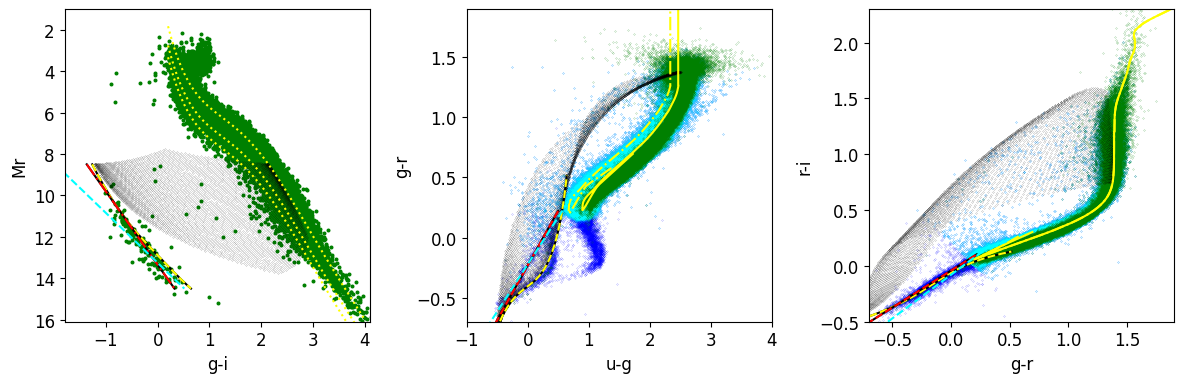

In [9]:
pp.plot3diagsBobAbel(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2, WD, WDMD) 

made plot: plot3diagsBA.png


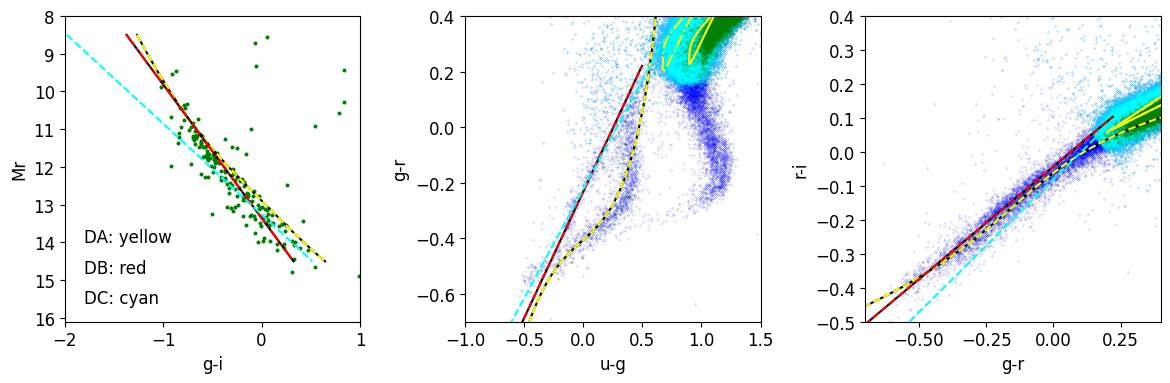

In [10]:
pp.plot3diagsBobAbel(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2, WD, WDMD, zoom=True)

## dump SDSS-Gaia data files for Bob Abel

In [11]:
t = s82gaiaPi
st = Table([t['ug'], t['gr'], t['ri'], t['iz'], t['Mr']],
           names=('ug', 'gr', 'ri', 'iz', 'Mr'),
           meta={'name': 's82gaiaPi'})
st.write('s82gaiaPi.csv', format='ascii', delimiter=',', overwrite=True) 

In [12]:
t = s82gaiaB
st = Table([t['ug'], t['gr'], t['ri'], t['iz'], t['MrPho']],
           names=('ug', 'gr', 'ri', 'iz', 'Mr'),
           meta={'name': 's82gaiaB'})
st.write('s82gaiaB.csv', format='ascii', delimiter=',', overwrite=True) 

## BHB models based on Sirko et al. 2004 (AJ 127, 899) 

In [99]:
BHB = ascii.read(datafile, format='no_header', delimiter=' ', data_start=0, names=names)

## Final WD models: based on Bergeron et al. models (Feb 1, 2024)

In [56]:
datafile = '../data/LocusData/WDAmodel.csv'
WDAn = pd.read_csv(datafile)
datafile = '../data/LocusData/WDBCmodel.csv'
WDBCn = pd.read_csv(datafile)
datafile = '../data/LocusData/WDMDfits.csv' 
WDMD2 = pd.read_csv(datafile)

In [14]:
WDnew = WD
WDnew['DAug'] = WDAn['ug']
WDnew['DAgr'] = WDAn['gr']
WDnew['DAri'] = WDAn['ri']
WDnew['DAiz'] = WDBCn['iz']
WDnew['DBug'] = WDBCn['ug']
WDnew['DBgr'] = WDBCn['gr']
WDnew['DBri'] = WDBCn['ri']
WDnew['DBiz'] = WDBCn['iz']
WDnew['DCug'] = WDBCn['ug']
WDnew['DCgr'] = WDBCn['gr']
WDnew['DCri'] = WDBCn['ri']
WDnew['DCiz'] = WDBCn['iz']

In [26]:
# fix small offset in u-g color for DA (Hydrogen) models
WDnew['DAug'] = np.where(WDnew['DAgr']<-0.3, WDnew['DAug']-0.1, WDnew['DAug'])
dgr = WDnew['DAgr'] + 0.25
WDnew['DAug'] = np.where(((WDnew['DAgr']>-0.3)&(WDnew['DAgr']<-0.25)), WDnew['DAug']+2*dgr, WDnew['DAug'])

made plot: plot3diagsBA.png


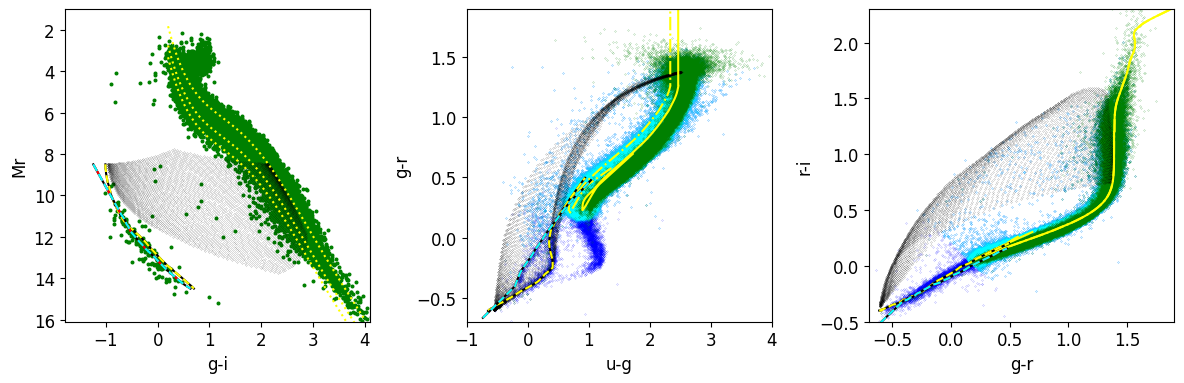

In [101]:
pp.plot3diagsBobAbel(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2, WDnew, WDMD2, BHB) 
!cp plot3diagsBA.png plot3diagsBA_DAd.png

made plot: plot3diagsBA.png


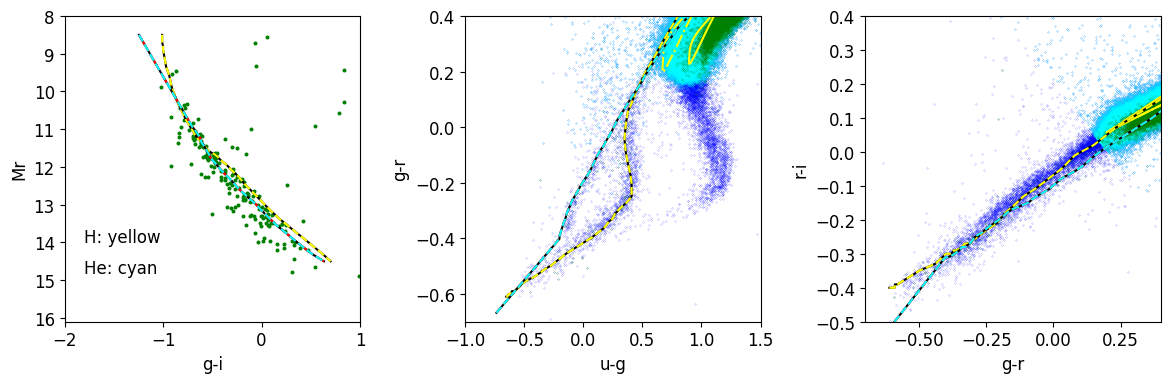

In [98]:
pp.plot3diagsBobAbel(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2, WDnew, WDMD2, BHB, zoom=True) 
!cp plot3diagsBA.png plot3diagsBAzoom.png

## now dump final versions of the Mr vs. color models for H, He and unresolved binaries

In [66]:
## store in a data file  
fout = open('../data/LocusData/WD_Hydrogen_MrColorSequences.txt', "w")
fout.write("## Mr-color sequences for H (DA) white dwarfs. \n")
fout.write("## Based on Bergeron et al. (1995) models, adjusted to fit SDSS data. \n")
fout.write("## For details, see Palaversa et al. (2024). \n")
fout.write("    Mr     ug       gr       ri       iz \n")
for i in range(0,len(WDnew)):
    # input values from TRILEGAL
    r1 = WDnew['Mr'][i]
    r2 = WDnew['DAug'][i]
    r3 = WDnew['DAgr'][i]
    r4 = WDnew['DAri'][i]
    r5 = WDnew['DAiz'][i]
    s = str("%7.2f " % r1) + str("%7.3f  " % r2) + str("%7.3f  " % r3) + str("%7.3f  " % r4)
    s = s + str("%7.3f  " % r5)  
    s = s + "\n"
    fout.write(s)             
fout.close() 

In [45]:
## store in a data file  
fout = open('../data/LocusData/WD_Helium_MrColorSequences.txt', "w")
fout.write("## Mr-color sequences for He (DB and DC) white dwarfs. \n")
fout.write("## Based on Bergeron et al. (1995) models, adjusted to fit SDSS data. \n")
fout.write("## For details, see Palaversa et al. (2024). \n")
fout.write("    Mr     ug       gr       ri       iz \n")
for i in range(0,len(WDnew)):
    # input values from TRILEGAL
    r1 = WDnew['Mr'][i]
    r2 = WDnew['DBug'][i]
    r3 = WDnew['DBgr'][i]
    r4 = WDnew['DBri'][i]
    r5 = WDnew['DBiz'][i]
    s = str("%7.2f " % r1) + str("%7.3f  " % r2) + str("%7.3f  " % r3) + str("%7.3f  " % r4)
    s = s + str("%7.3f  " % r5)  
    s = s + "\n"
    fout.write(s)             
fout.close() 

In [47]:
WDMD2

,DAh_rfratio,DAh_Mr,DAh_ug,DAh_gr,DAh_ri,DAh_iz,DAh_deltaMr,DAd_rfratio,DAd_Mr,DAd_ug,...,DBCh_ri,DBCh_iz,DBCh_deltaMr,DBCd_rfratio,DBCd_Mr,DBCd_ug,DBCd_gr,DBCd_ri,DBCd_iz,DBCd_deltaMr
0,1.000000,7.747425,-0.378210,-0.042013,0.139587,0.090025,0.0,1.000000,7.747425,-0.398752,...,0.088824,0.077491,0.0,1.000000,7.747425,-0.587908,-0.068572,0.285476,0.224547,0.0
1,1.096478,7.796274,-0.394919,-0.072712,0.131498,0.088976,-0.1,1.096478,7.796274,-0.411517,...,0.077933,0.075661,-0.1,1.096478,7.796274,-0.600231,-0.104386,0.277191,0.228184,-0.1
2,1.202264,7.842826,-0.409966,-0.102971,0.122818,0.087499,-0.2,1.202264,7.842826,-0.423198,...,0.066383,0.073349,-0.2,1.202264,7.842826,-0.611499,-0.139025,0.267684,0.231352,-0.2
3,1.318257,7.887096,-0.423486,-0.132644,0.113443,0.085725,-0.3,1.318257,7.887096,-0.433870,...,0.054071,0.070687,-0.3,1.318257,7.887096,-0.621788,-0.172421,0.257142,0.234150,-0.3
4,1.445440,7.929108,-0.435645,-0.161570,0.103603,0.083607,-0.4,1.445440,7.929108,-0.443656,...,0.041242,0.067626,-0.4,1.445440,7.929108,-0.631217,-0.204472,0.245316,0.236334,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,0.691831,13.529108,1.231598,0.998321,1.514793,0.981388,0.4,0.691831,13.529108,1.230328,...,1.509137,0.982324,0.4,0.691831,13.529108,1.307624,0.985803,1.509137,0.982324,0.4
3717,0.758578,13.587096,1.212740,0.974697,1.493144,0.978160,0.3,0.758578,13.587096,1.212254,...,1.487057,0.979152,0.3,0.758578,13.587096,1.290960,0.961778,1.487057,0.979152,0.3
3718,0.831764,13.642826,1.194655,0.951254,1.469768,0.974407,0.2,0.831764,13.642826,1.194744,...,1.463219,0.975456,0.2,0.831764,13.642826,1.274767,0.937948,1.463219,0.975456,0.2
3719,0.912011,13.696274,1.177174,0.928086,1.444031,0.970122,0.1,0.912011,13.696274,1.177524,...,1.436985,0.971227,0.1,0.912011,13.696274,1.258754,0.914406,1.436985,0.971227,0.1


In [57]:
WDbin = WDMD2

made plot: plot3diagsBA.png


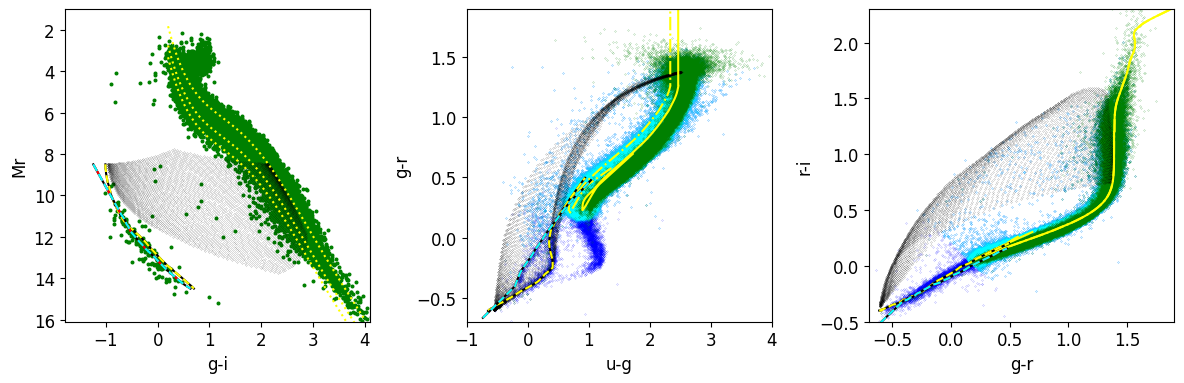

In [58]:
pp.plot3diagsBobAbel(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2, WDnew, WDbin, BHB) 
!cp plot3diagsBA.png plot3diagsBA_DAd.png

made plot: plot3diagsBA.png


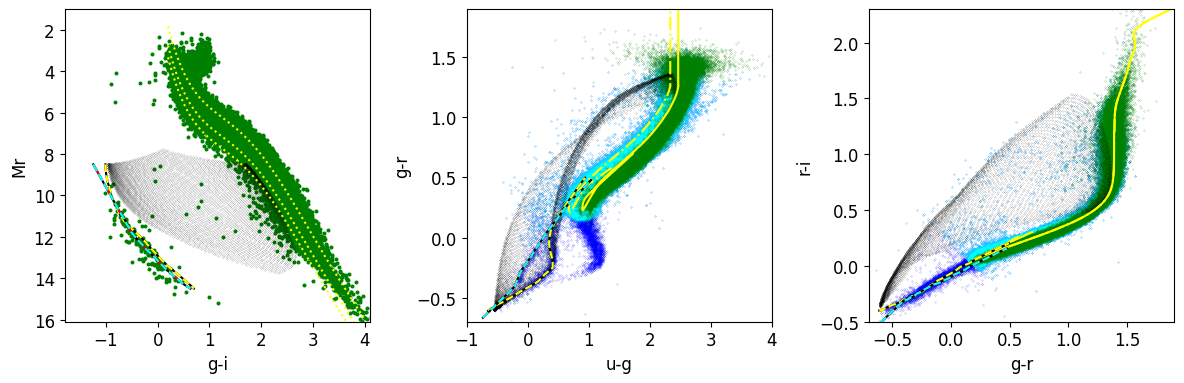

In [59]:
WDbin['DAd_Mr'] = WDbin['DAh_Mr'] 
WDbin['DAd_ug'] = WDbin['DAh_ug'] 
WDbin['DAd_gr'] = WDbin['DAh_gr'] 
WDbin['DAd_ri'] = WDbin['DAh_ri'] 
pp.plot3diagsBobAbel(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2, WDnew, WDbin, BHB) 
!cp plot3diagsBA.png plot3diagsBA_DAh.png

made plot: plot3diagsBA.png


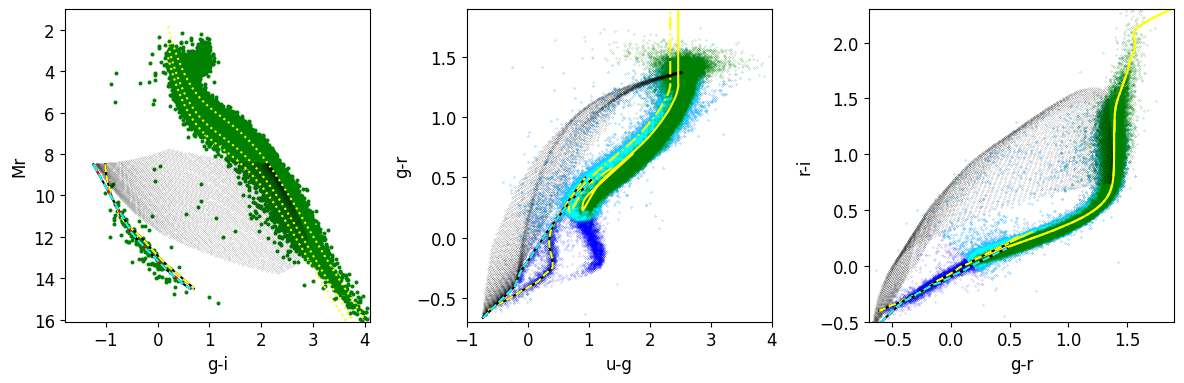

In [60]:
WDbin['DAd_Mr'] = WDbin['DBCd_Mr'] 
WDbin['DAd_ug'] = WDbin['DBCd_ug'] 
WDbin['DAd_gr'] = WDbin['DBCd_gr'] 
WDbin['DAd_ri'] = WDbin['DBCd_ri'] 
pp.plot3diagsBobAbel(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2, WDnew, WDbin, BHB) 
!cp plot3diagsBA.png plot3diagsBA_DBCd.png

made plot: plot3diagsBA.png


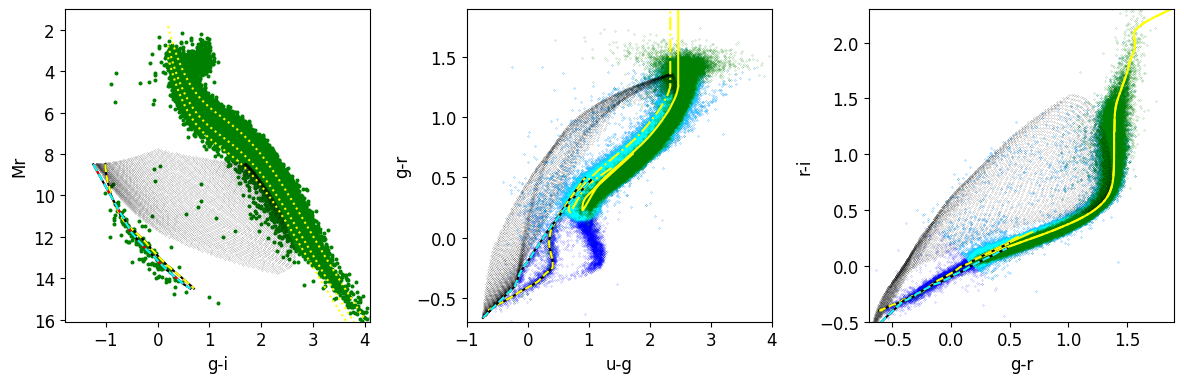

In [61]:
WDbin['DAd_Mr'] = WDbin['DBCh_Mr'] 
WDbin['DAd_ug'] = WDbin['DBCh_ug'] 
WDbin['DAd_gr'] = WDbin['DBCh_gr'] 
WDbin['DAd_ri'] = WDbin['DBCh_ri'] 
pp.plot3diagsBobAbel(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2, WDnew, WDbin, BHB) 
!cp plot3diagsBA.png plot3diagsBA_DBCh.png

In [68]:
datafile = '../data/LocusData/WDMDfits.csv' 
WDMD2 = pd.read_csv(datafile)

In [73]:
## store unresolved binaries in a data file  
def dumpWDMD(df, outputFile, firstLine, binType):
    fout = open(outputFile, "w")
    fout.write(firstLine)
    fout.write("## Mr is the total, dMr is the difference between WD and MD. \n")
    fout.write("## For details, see Palaversa et al. (2024). \n")
    fout.write("    Mr     ug       gr       ri       iz       dMr\n")
    for i in range(0,len(WDnew)):
        r1 = df[binType+'_Mr'][i]
        r2 = df[binType+'_ug'][i]
        r3 = df[binType+'_gr'][i]
        r4 = df[binType+'_ri'][i]
        r5 = df[binType+'_iz'][i]
        r6 = df[binType+'_deltaMr'][i]
        s = str("%7.2f " % r1) + str("%7.3f  " % r2) + str("%7.3f  " % r3) + str("%7.3f  " % r4)
        s = s + str("%7.3f  " % r5) + str("%6.2f  " % r6)  
        s = s + "\n"
        fout.write(s)             
    fout.close() 

In [75]:
# DAd
outFile = '../data/LocusData/WDMD_DAd_MrColorSequences.txt'
firstLine = "## Mr-color sequences for H (DA) white dwarf plus M dwarf with [Fe/H] = 0.0 \n"
dumpWDMD(WDMD2, outFile, firstLine, 'DAd')
# DAh
outFile = '../data/LocusData/WDMD_DAh_MrColorSequences.txt'
firstLine = "## Mr-color sequences for H (DA) white dwarf plus M dwarf with [Fe/H] = -1.5 \n"
dumpWDMD(WDMD2, outFile, firstLine, 'DAh')
# DBCd
outFile = '../data/LocusData/WDMD_DBCd_MrColorSequences.txt'
firstLine = "## Mr-color sequences for He (DB+DC) white dwarf plus M dwarf with [Fe/H] = 0.0 \n"
dumpWDMD(WDMD2, outFile, firstLine, 'DBCd')
# DBCh
outFile = '../data/LocusData/WDMD_DBCh_MrColorSequences.txt'
firstLine = "## Mr-color sequences for He (DB+DC) white dwarf plus M dwarf with [Fe/H] = -1.5 \n"
dumpWDMD(WDMD2, outFile, firstLine, 'DBCh')